# Lesson 12 - Introduction to NLP

> Introduction to Natural Language Processing (NLP).

## Learning objectives
In this lecture we cover the basics of NLP to build a sentiment classifier in scikit-learn. The learning goals are:
* Know the basics of string processing in python
* Preprocessing steps in NLP
* Count and TF-IDF encodings
* Sentiment classification workflow

## References
* Chapter 10: Representing and Mining Text in _Data Science for Business_ by F. Provost and P. Fawcett

## Homework
As homework read the references, work carefully through the notebook, solve the exercises, and read this explanation on the [Naive Bayes classifier](https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c). 

## Introduction to NLP
Natural language processing (NLP) concerns the part of Machine Learning about the analysis of digital, human written texts. The topic of NLP is as old as machine learning itself and dates back to Alan Turing himself. Since text is a widely used medium there are plenty of applications of machine learning:

- Text classification
- Question/answering systems
- Dialogue systems
- Summarization
- Text generation
etc.

Especially in the past few years there has been exciting and rapid progress in the field. If you want to try your own examples you can do so at [talktotransformer.com](https://talktotransformer.com/) or read the original article on [OpenAI's webpage](https://openai.com/blog/better-language-models/).Natural text is different to other data sources such as numerical tables or images. One way to look at text is to consider each word to be a feature. Since most languages have of the order of 100k words in their vocabulary plus many variations this leads to an enormous feature space. At the same time most words in the vocabulary do not appear in a small text. This leads to extreme sparsity. These properties call for a different approach to NLP than the methods we encountered and used for tabular data.

## Notebook overview
The goal of this notebook is to classify movie reviews in terms of positive or negative feedback. This task is called sentiment analysis and is a common NLP application. As a company you might use a sentiment classifier to analyse customer feedback or detect toxic comments on your website.

Text data can be messy and require some clean up. The specific steps for the clean-up can depend on how the data was generated or where it was found. Text from the web might have some html artifacts that need cleaning or product reviews could include meta information on the review. Python offers powerful tools to manipulate strings.

Once the text is cleaned we have to encode it in a way that machine learning methods can handle. Directly using text as input is not possible. Most machine learning methods can only handle numerical data such as vectors and matrices. So we have to encode the input texts as vectors or matrices. These text representations are called vector encodings. Furthermore, we look at n-grams to keep some of the sequential structure of text.

Finally, we can train a model to classify the movie review texts. However, the Random Forest models we already know well do not work well for the high-dimensional data. We introduce a new methods that is common for text data called the Naïve Bayes classifier that utilises Bayes theorem.



## Imports

In [2]:
import pandas as pd
import numpy as np
import pickle

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
tqdm.pandas(desc="progress")

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joelt\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joelt\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


## Part 1: Dataset

First, we load the IMDB dataset as a dataframe. Note that this is not the original dataset from [here](https://ai.stanford.edu/~amaas/data/sentiment/), but a version that I pre-processed for the ease of use.

In [3]:
df_imdb = pd.read_csv('imdb.csv')

In [28]:
df_imdb.shape

(50000, 5)

In [4]:
df_imdb.head()

,filename,text,sentiment,train_label
0,4715_9,For a movie that gets no respect there sure ar...,pos,train
1,12390_8,Bizarre horror movie filled with famous faces ...,pos,train
2,8329_7,"A solid, if unremarkable film. Matthau, as Ein...",pos,train
3,9063_8,It's a strange feeling to sit alone in a theat...,pos,train
4,3092_10,"You probably all already know this by now, but...",pos,train


The dataset consists of a `filename`, `text`, `sentiment` and a `train_label`. The latter splits the data into a train and test set which is used as the official benchmark. We will follow that same split. 

But first we want to make the `sentiment` column categorical:

In [5]:
df_imdb['sentiment'] = df_imdb['sentiment'].astype('category')

Now, let's have a look at a few text examples. For that purpose we wrote a helper function to print examples from the dataset:

In [6]:
def print_n_samples(df, n):
    """
    Helper function to print data samples from IMDB dataset.
    """
    for i in range(n):
        print('SAMPLE', i+1, '\n')
        df_sample = df.sample(1)
        print(df_sample['text'].values[0])
        print('\nSentiment:', df_sample['sentiment'].values[0],'\n')
        print("".join(100*['=']))

We can show a few examples:

In [11]:
print_n_samples(df_imdb, 2)

SAMPLE 1 

I was hoping this would be of the calibre of Das Boot and echo the stark realism created by acclaimed German Director Leni RiefenStahl in her documentaries, sadly I was monumentally disappointed. The story line is implausible and defies credulity. An RAF airman is shot down and somehow finds his way to a hospital in Dresden. Anna a nurse whose father runs the hospital and is about to become engaged to a doctor she works with falls in love with the airman and they make love. The next evening at a lavish engagement party the airman turns up disguised as a German officer and dances with Anna. Although well directed and acted, to me it is soap opera of the lowest order.

Sentiment: neg 

SAMPLE 2 

This B&W film reached the spartan movie house of my Frisian village about 18 months after its release. In those days much of our full-length comedy fare hailed from Denmark (Nils Poppe anyone?) so this movie struck like a thunderbolt -- it had me weeping with helpless mirth, ROTFL as 

We can see that the reviews are medium sized texts with positive and negative labels.

### Exercise 1
A few exploratory and processing tasks:
* Describe the distribution of positive and negative comments in the train and test dataset.
* Study the distribution of the text lengths. You can perform string operations on a `pandas.DataFrame` by accessing the `str` object of a column: `df['YOUR_TEXT_COLUMN'].str.len()`.

<AxesSubplot:xlabel='Type', ylabel='Amount'>

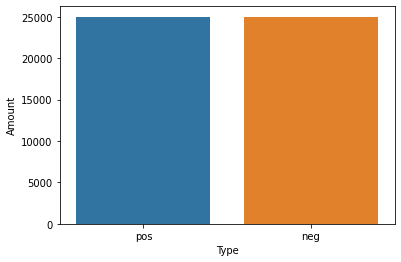

In [25]:
number_pos = df_imdb.loc[df_imdb["sentiment"] == "pos"].shape[0]
number_neg = df_imdb.loc[df_imdb["sentiment"] == "neg"].shape[0]

plot_dict :dict = {
    "Type" :        ['pos', 'neg'],
    "Amount" :      [number_pos, number_neg]
}

df_plot = pd.DataFrame(plot_dict)

sns.barplot(data = df_plot, x = "Type", y = "Amount")

In [35]:
df_plot

,Type,Amount
0,pos,25000
1,neg,25000


In [39]:
df_imdb["text_len"] = df_imdb["text"].str.len()
df_imdb.head()

,filename,text,sentiment,train_label,count,text_len
0,4715_9,For a movie that gets no respect there sure ar...,pos,train,1,284
1,12390_8,Bizarre horror movie filled with famous faces ...,pos,train,1,1033
2,8329_7,"A solid, if unremarkable film. Matthau, as Ein...",pos,train,1,318
3,9063_8,It's a strange feeling to sit alone in a theat...,pos,train,1,2596
4,3092_10,"You probably all already know this by now, but...",pos,train,1,783


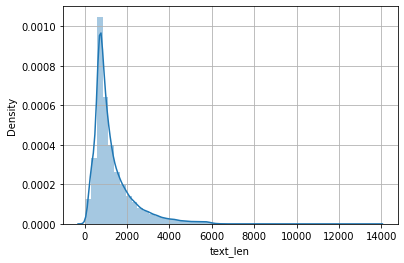

In [51]:
sns.distplot(df_imdb["text_len"])
plt.grid(True)

In [56]:
print(f"Mean:\t", df_imdb["text_len"].mean())
print("Median:\t", df_imdb["text_len"].median())

Mean:	 1309.43102
Median:	 970.0


## Part 2: Preprocessing

In this section we have a look at the basics of string processing. Being able to filter/combine/manipulate strings is a crucial skill to do natural language processing.

Cleaning up text for NLP tasks usually involves the following steps.
* Normalization
* Tokenization
* Remove stop-words
* Remove non-alphabetical tokens
* Stemming

Some of the steps might not be necessary or you need to add steps depending on the text, task and method. For our task these steps are fine. We apply these steps on one text as an example and then build a function to apply it to all texts.


### String processing in Python
Python offers powerful properties and functions to manipulate strings. Let's preprocess the texts in the dataset to bring them to a cleaner form. Fortunately we don't need to implement everything from scratch. One of the richest Python libraries to process texts is the Natural Language Toolkit (NLTK) which offers some powerful functions we will use.


### Input
We see that the raw text has several features such as capitalisation, special characters, numericals and puncuations. 

In [57]:
text = df_imdb.loc[0, 'text']
print(text)

For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.


### Normalize
This is the process of transforming the text to lower-case.

In [58]:
text = text.lower()
print(text)

for a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. imagine a movie where joe piscopo is actually funny! maureen stapleton is a scene stealer. the moroni character is an absolute scream. watch for alan "the skipper" hale jr. as a police sgt.


### Tokenize
Now we split the text in words/tokens.

In [59]:
tokens = word_tokenize(text)
print(tokens)

['for', 'a', 'movie', 'that', 'gets', 'no', 'respect', 'there', 'sure', 'are', 'a', 'lot', 'of', 'memorable', 'quotes', 'listed', 'for', 'this', 'gem', '.', 'imagine', 'a', 'movie', 'where', 'joe', 'piscopo', 'is', 'actually', 'funny', '!', 'maureen', 'stapleton', 'is', 'a', 'scene', 'stealer', '.', 'the', 'moroni', 'character', 'is', 'an', 'absolute', 'scream', '.', 'watch', 'for', 'alan', '``', 'the', 'skipper', "''", 'hale', 'jr.', 'as', 'a', 'police', 'sgt', '.']


### Stop Words
Next, we remove words that are too common and don't add to the content of sentences. These words are commonly called 'stop words'. NLTK provides a list of stop words:

In [60]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'needn', 'when', 'has', "couldn't", 'so', 'and', 'aren', 'himself', 'not', 'mightn', 'a', 'yourselves', 'above', 'wasn', 'who', 'how', 'for', 'him', 'won', 'again', "aren't", 'didn', "you've", 'they', 'now', "wouldn't", 'doesn', 'shan', 'will', 'by', 'own', 'myself', 'further', 'd', "you'll", 'me', 'did', 've', 'other', 'themselves', 'have', 'very', 'between', 'during', 're', 'no', "shan't", 'or', 'hasn', 'don', 'weren', "mightn't", 'herself', 'we', 'he', 'wouldn', 'her', 'having', 'up', 'yours', 'most', 's', 'shouldn', "should've", 'does', 'those', 'hadn', "hadn't", 'if', 'such', 'through', 'after', 'being', 'too', 'about', 'because', 'at', 'an', 'its', "hasn't", 'once', 'some', 'below', 'why', 'which', 'y', 'ain', 'mustn', 'my', "you're", 'am', 'there', 'doing', 'any', 't', "haven't", 'be', 'were', 'under', 'of', 'out', 'more', 'before', 'o', 'this', 'into', "she's", 'had', 'same', 'while', 'just', 'each', 'these', 'hers', 'only', "it's", 'is', 'do', 'his', 'them', "wasn't", 'agains

We keep only the words that are **not** in the list of stop words.

In [61]:
tokens = [i for i in tokens if not i in stop_words]
print(tokens)

['movie', 'gets', 'respect', 'sure', 'lot', 'memorable', 'quotes', 'listed', 'gem', '.', 'imagine', 'movie', 'joe', 'piscopo', 'actually', 'funny', '!', 'maureen', 'stapleton', 'scene', 'stealer', '.', 'moroni', 'character', 'absolute', 'scream', '.', 'watch', 'alan', '``', 'skipper', "''", 'hale', 'jr.', 'police', 'sgt', '.']


### Punctuation
We also want to remove all tokens that are not composed of letters (e.g. punctuation and numbers). We can check if a token is only composed of alphabetic letters with the `isalpha()` and filter with it:

In [62]:
tokens = [i for i in tokens if i.isalpha()]
print(tokens)

['movie', 'gets', 'respect', 'sure', 'lot', 'memorable', 'quotes', 'listed', 'gem', 'imagine', 'movie', 'joe', 'piscopo', 'actually', 'funny', 'maureen', 'stapleton', 'scene', 'stealer', 'moroni', 'character', 'absolute', 'scream', 'watch', 'alan', 'skipper', 'hale', 'police', 'sgt']


### Stemming
As a final step we want to trim the words to the stem. This helps drastically decrease the vocabulary size and maps similar/same words onto the same word. E.g. plural/singular words or different forms of verbs:
* pen, pens --> pen
* happy, happier --> happi
* go, goes --> go

There are several languages available in nltk since this is a **language dependant process**:

In [63]:
print(SnowballStemmer.languages)

('arabic', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'hungarian', 'italian', 'norwegian', 'porter', 'portuguese', 'romanian', 'russian', 'spanish', 'swedish')


Applied to the text sample, this yields:

In [64]:
stemmer = SnowballStemmer("english")
tokens = [stemmer.stem(i) for i in tokens]
print(tokens)

['movi', 'get', 'respect', 'sure', 'lot', 'memor', 'quot', 'list', 'gem', 'imagin', 'movi', 'joe', 'piscopo', 'actual', 'funni', 'maureen', 'stapleton', 'scene', 'stealer', 'moroni', 'charact', 'absolut', 'scream', 'watch', 'alan', 'skipper', 'hale', 'polic', 'sgt']


### Preprocessing function

In [65]:
def preprocessing(text, language='english', stemming=True):
    """
    preprocess a string and return processed tokens.
    args:
        text: text string
    return:
        tokens: list of processed and cleaned words
    """
    
    stop_words = set(stopwords.words(language))
    stemmer = SnowballStemmer(language)    
    
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [i for i in tokens if not i in stop_words]
    tokens = [i for i in tokens if i.isalpha()]
    if stemming:
        tokens = [stemmer.stem(i) for i in tokens]
    
    return tokens

Finally, we can apply these steps to all texts. We use the `apply` function of pandas which applies a function to every entry in a DataFrame column. Since we registered `tqdm` we can use the `progress_apply` function which uses `apply` and adds a progress bar to it.

In [66]:
df_imdb['text_processed_stemmed'] = df_imdb['text'].progress_apply(preprocessing) # add new column

progress: 100%|██████████| 50000/50000 [02:28<00:00, 335.66it/s]


## Part 3: Vector encoding

### Vectorizer

Now that we cleaned up and tokenized the text corpus we are now ready to encode the texts in vectors. In class we had a look at simple **one-hot encodings** that can be extended to count encodings and **TF-IDF encodings**.

TF-IDF stands is for term frequency–inverse document frequency and is a metric that indicates how important a token is in a document.

Scikit-learn comes with functions to do both count and TF-IDF encodings on text. The interface is very similar to the classifier just the `predict` step is replaced with `transform`:

```python
count_vectorizer = CountVectorizer(your_settings)
count_vectorizer.fit(your_dataset)
vec = count_vectorizer.transform('your_text')
```

This creates a vectorizer that can transform texts to vectors. We can also limit the number of words take into account when building the vector. This limits the vector size and cuts off words that occur rarely. If you set `max_features=10000` only the 10000 most occurring words are used to build the vector and all rare words are excluded. This means that the encoding vector then has a dimension of 10000. For now we take all words (`max_features=None`). Since we used our own tokenizer and preprocessing step we overwrite the standard steps in the vectorizer library with the `vec_default_settings`.

In [67]:
vec_default_settings = {'analyzer':'word', 'tokenizer':lambda x: x, 'preprocessor':lambda x: x, 'token_pattern':None,}

In [68]:
# TF-IDF vectorizer
tfidf_vec = TfidfVectorizer(max_features=None, **vec_default_settings)

# Count vectorizer
count_vec = CountVectorizer(max_features=None, **vec_default_settings)

Let's test both vectorizers on a small, dummy dataset with **4 documents**:

In [69]:
corpus = [
    ['this','is','the','first','document','in','the','corpus'],
    ['this','document','is','the','second','document','in','the','corpus'],
    ['and','this','is','the','third','one','in','this','corpus'],
    ['is','this','the','first','document','in','this','corpus'],
]

Now we fit a count vectorizer to the data.

In [70]:
count_vec.fit(corpus)

CountVectorizer(preprocessor=<function <lambda> at 0x0000014A99972790>,
                token_pattern=None,
                tokenizer=<function <lambda> at 0x0000014A99972160>)

Once a vectorizer is fitted, we can investigate the vocabulary. It is a dictionary that points each word to the index in the vector it corresponds to. For example the word `'this'` corresponds to the 10+1-nth (+1 because we start counting at zero) entry in the vector and the word `'and'` corresponds to the first entry.

In [71]:
len(count_vec.vocabulary_)

11

In [72]:
count_vec.vocabulary_

{'this': 10,
 'is': 5,
 'the': 8,
 'first': 3,
 'document': 2,
 'in': 4,
 'corpus': 1,
 'second': 7,
 'and': 0,
 'third': 9,
 'one': 6}

Now we can transform the corpus and get a list of vectors in the form of a matrix (each row corresponds to a document vector). For instance, the first row contains how frequently each vocabulary element occurs in the first row of the corpus.

In [73]:
X = count_vec.transform(corpus)
print(X.toarray())

[[0 1 1 1 1 1 0 0 2 0 1]
 [0 1 2 0 1 1 0 1 2 0 1]
 [1 1 0 0 1 1 1 0 1 1 2]
 [0 1 1 1 1 1 0 0 1 0 2]]


If we now do the same thing with the TF-IDF vectorizer we see that the output looks different:

In [74]:
tfidf_vec.fit(corpus)
X = tfidf_vec.transform(corpus)
print(X.toarray())

[[0.         0.29137467 0.35639305 0.44021632 0.29137467 0.29137467
  0.         0.         0.58274934 0.         0.29137467]
 [0.         0.23798402 0.58217725 0.         0.23798402 0.23798402
  0.         0.45604658 0.47596805 0.         0.23798402]
 [0.43943636 0.22931612 0.         0.         0.22931612 0.22931612
  0.43943636 0.         0.22931612 0.43943636 0.45863224]
 [0.         0.29137467 0.35639305 0.44021632 0.29137467 0.29137467
  0.         0.         0.29137467 0.         0.58274934]]


* The shape of the matrix is the same.
* Instead of integers (corresponding to counts) we have continous values.
* Elements that occur in multilple documents have lower scores than those appearing in fewer.

This should just illustrate that different vectorizers are available but we do not go into detail on them. Now let's apply this to our dataset and create encodings with `100000` words:

### n-grams
When we use a count or TF-IDF vectorizer we throw away all sequential information in the texts. From the vector encodings above we could not reconstruct the original sentences. For this reason these encodings are called Bag-of-Words encodings (all words go in a bag and are shuffeled). However, sequential information can be important for the meaning of a sentence. As an example imagine the sentence:

```Python
text = 'The movie was good and not bad.'
```

It is important to know if the word `'not'` is in front of `'good'` or `'bad'` for determining the sentiment of the sentence. We can preserve some of that information by using n-grams. Instead of just encoding single words we can also encode tuple, triplets etc. called n-grams. The n encodes how many words we bundle together. 

The vectorizers can do this for us if we provide them a range of n's we want to include. In the following example we encode the text in 1- and 2-grams.

In [75]:
count_vec = CountVectorizer(max_features=None, ngram_range=(1,2), **vec_default_settings)

In [76]:
count_vec.fit(corpus)

CountVectorizer(ngram_range=(1, 2),
                preprocessor=<function <lambda> at 0x0000014A99972790>,
                token_pattern=None,
                tokenizer=<function <lambda> at 0x0000014A99972160>)

We can see that this drastically increases the vocabulary.

In [77]:
len(count_vec.vocabulary_)

30

Now the vocabulary also contains word tuples next to the words:

In [78]:
count_vec.vocabulary_

{'this': 25,
 'is': 11,
 'the': 18,
 'first': 6,
 'document': 3,
 'in': 8,
 'corpus': 2,
 'this is': 28,
 'is the': 12,
 'the first': 20,
 'first document': 7,
 'document in': 4,
 'in the': 9,
 'the corpus': 19,
 'second': 16,
 'this document': 27,
 'document is': 5,
 'the second': 21,
 'second document': 17,
 'and': 0,
 'third': 23,
 'one': 14,
 'and this': 1,
 'the third': 22,
 'third one': 24,
 'one in': 15,
 'in this': 10,
 'this corpus': 26,
 'is this': 13,
 'this the': 29}

The encodings look very similar but are larger due to the larger vocabulary:

In [79]:
X = count_vec.transform(corpus)
print(X.toarray())

[[0 0 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 2 1 1 0 0 0 0 1 0 0 1 0]
 [0 0 1 2 1 1 0 0 1 1 0 1 1 0 0 0 1 1 2 1 0 1 0 0 0 1 0 1 0 0]
 [1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 2 1 0 1 0]
 [0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 2 1 0 0 1]]


### Vectorize dataset
Now we want to encode the real text. We put an upper limit on the vocabulary size. Since there are a lot of unique words in our corpus there are a lot of combinations of words.

In [80]:
max_features=100000
ngrams=(1,3)

count_vec = CountVectorizer(max_features=max_features, ngram_range=ngrams, **vec_default_settings)

In the example above we used the `fit` and `transform` function. We can avoid these two steps with the combined function `fit_transform`. First we need to split the dataset:

In [81]:
text_train = df_imdb.loc[df_imdb['train_label']=='train', 'text_processed_stemmed']
text_test = df_imdb.loc[df_imdb['train_label']=='test', 'text_processed_stemmed']

In [82]:
X_train = count_vec.fit_transform(text_train)
X_test = count_vec.transform(text_test)

This yields a vocabulary with `100000` entries:

In [83]:
len(count_vec.vocabulary_)

100000

Looking at the shape of the returned matrix we see that it still has as many rows as the input but now has `100000` entries per row (the feature vector).

In [84]:
X_train.shape

(25000, 100000)

## Part 4: Sentiment classification

Now that we featurised the text, we can train a model on it. In this section we will use a Naïve Bayes classifier to determine whether a review is positive or negative. (For an explanation of the classifier, please read [this review](https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c).) 

First, we split the labels of the training and test set:

In [85]:
y_train = df_imdb.loc[df_imdb['train_label']=='train', 'sentiment']
y_test = df_imdb.loc[df_imdb['train_label']=='test', 'sentiment']

We can initialise a Naïve Bayes classifier the same way we initialised the Random Forest models. Also the fit/predict interface is the same.

In [86]:
nb_clf = MultinomialNB()

In [87]:
%%time
nb_clf.fit(X_train, y_train)

CPU times: total: 78.1 ms
Wall time: 94.3 ms


MultinomialNB()

In [88]:
y_pred = nb_clf.predict(X_test)

We can calculate the prediction accuracy on the test set:

In [89]:
accuracy_score(y_test, y_pred)

0.8524

### Random Forest
We can compare the Naïve Bayes model with a Random Forest on the same task with the same input data.

In [90]:
rf_clf = RandomForestClassifier(n_jobs=-1)

In [91]:
%%time
rf_clf.fit(X_train, y_train)

CPU times: total: 2min 4s
Wall time: 18 s


RandomForestClassifier(n_jobs=-1)

In [42]:
y_pred = rf_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.85716

We can see that we get similar performance while being **~1000x faster**!

### Exercise 2
Retrain the model with a TF-IDF encoding instead of the count encoding. Experiment with the n-gram setting and run the experiment with the following settings: `(1,1)`, `(1,2)`, `(1,3)` and `(1,4)`. Which n-gram setting gives you the highest sentiment classification accuracy? And ideas why this setting gives the highest accuracy? 

In [ ]:
tfidf_vec.fit(corpus)
X = tfidf_vec.transform(corpus)
print(X.toarray())

In [ ]:
max_features=100000
ngrams=(1,3)

count_vec = CountVectorizer(max_features=max_features, ngram_range=ngrams, **vec_default_settings)

In [ ]:
X_train = count_vec.fit_transform(text_train)
X_test = count_vec.transform(text_test)